# <center> **IMA205 : Challenge 2021**
# <center> Pap smear cells classification
### Realized by : **Siwar** **_MHADHBI_**

# Introduction

> $~~~$
Cervical cancer is one of the leading causes of cancer death in females worldwide. The disease can be cured if the patient is diagnosed in the pre-cancerous lesion stage or earlier. A common physical examination technique widely used in the screening is Papanicolaou test or Pap test.
<br>
$~~~$The test is usually performed manually which is a tedious and an error prone task. Automating Pap smear based cervical cancer screening could alleviate the challenge related to the shortage of skilled manpower, mainly pathologists in developing countries.This is why the implementation of an efficient computer-assisted methodology for automated classification οf cell images is of uttermost importance. 
<br>
$~~~$ This is the main purpose of the present project which proposes different methods for automatic cervical cancer cell classification.



# Goal
> This project has two goals : 
1. **Binary classification** : Detection of abnormality in cells
2. **Multi-class Classification** : Assign cells to a specific group 


# Import useful modules

In [60]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import tensorflow
from PIL import Image
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import matthews_corrcoef
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Import useful functions from myfunctions.py file
from myfunctions import *

import warnings
warnings.filterwarnings('ignore')

sns.set(style='darkgrid')

# **Data Visualization**



For this project, we are provided with single-cell images with their cytoplasm segmentation and nucleus segmentation. We'll see next some examples. Along with images, a csv file containing binary and group labels is provided (_metadataTrain.csv_).<br><br>

This cell is necessary to retrieve data from google drive.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Working_dir = '/content/drive/MyDrive/TELECOMPARIS/IMA/Challenge/Data/'

In [4]:
## Retrieve labels 
labels = pd.read_csv(Working_dir + 'metadataTrain.csv') 
labels.head(10)

,ID,ABNORMAL,GROUP
0,1721,1,8
1,311,0,1
2,1502,1,7
3,4227,0,1
4,3604,1,7
5,3668,1,6
6,3669,1,7
7,376,1,8
8,635,0,0
9,971,1,7


* The first column of this dataframe represents the ID of cell images.
* The second column represents if the cell is abnormal (1) or normal (0). 
* The third column represents the group to which the cell belongs (from 0 to 8).

#### Visualize examples training single-cell images


************************* Cells classified as normal *************************




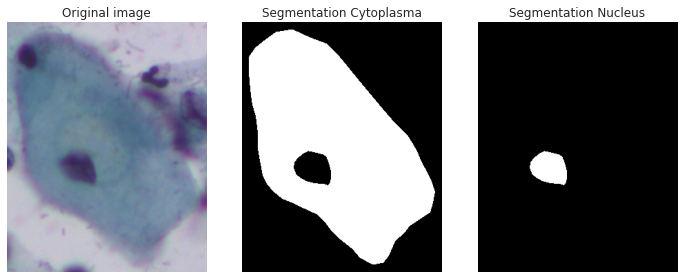

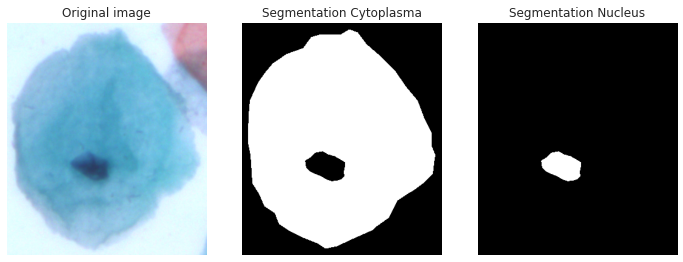



************************* Cells classified as abnormal *************************




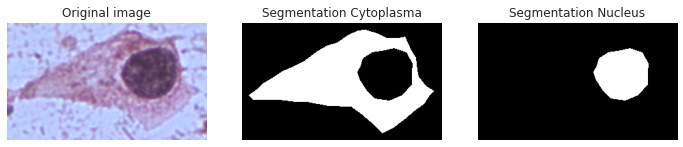

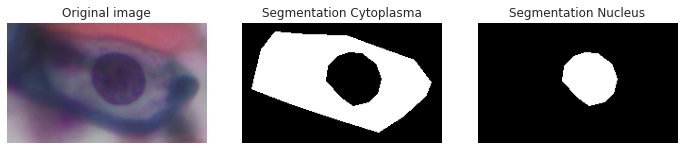

In [46]:
# Path to train images
path_images = Working_dir + 'Train'

print('\n************************* Cells classified as normal *************************\n\n')
plot_examples(path_images, 100)
plot_examples(path_images, 10)

print('\n\n************************* Cells classified as abnormal *************************\n\n')
plot_examples(path_images, 250)
plot_examples(path_images, 101)

**Comment:**

* We can clearly see through the above images that the two groups of cells have different characteristics especially regarding cytoplasm and nucleus regions. We can notice that cytoplasm and nucleus areas differ so much from normal to abnormal cells. <br><br>
Thus, we can say that specific features belonging to those two regions (Cytoplasm and Nucleus) can allow us to classify cell images automatically. This will be the subject of the first section which will be based on handcrafted features.

# **First Goal : Binary Classification**

In this section, we'll try to classify automatically cell images into normal and abnormal cells using machine learning algorithms based on handcrafted features.

As a first step, we extract features characterizing both cytoplasm and nucleus regions based on the provided segmentations which are defined manually by experts, as shown above.


In every region of interest (cytoplasm and nucleus), computed features are characterizing texture and shape of the region. In this project, the chosen features for extraction are based on _"""Pap-smear Benchmark Data for Pattern Classification"""_ paper $[1]$ with slight differences. 

The paper introduces as features: area, brightness, diameter, elongation, roundness, perimeter, Nucleus position, Maxima and Minima in each region of interest. In our case, we are provided with images from two different datasets (DTU/HERLEV $[2]$ and SIPaKMeD $[3]$ Databases). Thus, images have been acquired with different microscopes, so one pixel does not always refer to the same real-world size in mm. Consequently, we cannot just compute the area in mm² as results will be biased. Besides, we cannot just eliminate this feature since, as seen in previous images, cytoplasm and nucleus areas are by sight very important features for classification. Thus, we'll consider instead the ratio of number of pixels representing the area of the region of interest.

The extracted features based on texture and shape are presented in the following table$[1]$:


![](https://drive.google.com/uc?export=view&id=1A-ePh_B-Fn--_SBmcrPhJXr43GMgMIjq) <br>
Table1. Considered Features  [1]

Thus, In  this  work,  $18$  features have been extracted,  which  are computed  from  nucleus  and  cytoplasm  regions of  each  cell.

#### Extract features

The following cell computes the extracted features and saves them in a dataframe.

In [55]:
# NB. The extraction of 18 features for (2921 images only for training) takes a **very long time (more than 2 hours )**
# so they were extracted once and then saved into a csv file to be easily imported

# To test the extraction method just uncomment the following lines
#df_train = pd.DataFrame()
#df_train = extract_features(path_images, df_train)
#df_train

In [5]:
# Import extracted features saved in df_train.csv file
df_train = pd.DataFrame()
df_train = pd.read_csv('df_train.csv')
df_train

,Id,Narea,Carea,NCarea,Nlong,Clong,Nshort,Cshort,Nround,Cround,Nperim,Npos,Nmax,Cmax,Nmin,Cmin,Cperim,Nelong,Celong
0,2453,0.025005,0.552782,0.045235,54,253,51,246,0.161136,0.162279,73,0.206141,1900537,881282,1905847,912321,408,0.944444,0.972332
1,691,0.062571,0.458400,0.136499,60,200,38,97,0.117510,0.077480,93,0.571948,647347,363528,652458,383132,199,0.633333,0.485000
2,1927,0.114631,0.377636,0.303549,67,179,66,125,0.193095,0.089122,78,0.334683,685311,470556,692052,492001,10,0.985075,0.698324
3,4684,0.082627,0.482819,0.171135,67,150,47,141,0.132835,0.154861,70,0.069602,677398,372591,683063,393096,252,0.701493,0.940000
4,515,0.033899,0.531643,0.063762,50,210,44,191,0.172286,0.153175,77,0.172549,1268400,614522,1273383,639447,247,0.880000,0.909524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2933,0.017449,0.613954,0.028420,44,297,40,221,0.178061,0.137510,64,0.043900,2014913,809899,2019464,835988,358,0.909091,0.744108
2917,1171,0.016536,0.652446,0.025345,52,342,44,291,0.178880,0.163166,42,0.034224,2995728,1101547,3000705,1134648,484,0.846154,0.850877
2918,4424,0.008517,0.624165,0.013645,45,387,29,278,0.132068,0.130866,48,0.363974,3243733,1291032,3247836,1307462,514,0.644444,0.718346
2919,2134,0.012812,0.629361,0.020357,51,365,46,337,0.175140,0.167968,68,0.149986,3660044,1461360,3665242,1459839,475,0.901961,0.923288


**Comment:**

* As we see, we have $2921$ samples (cell images) identified by their 'Id' and $18$ features.

1    1619
0    1302
Name: ABNORMAL, dtype: int64

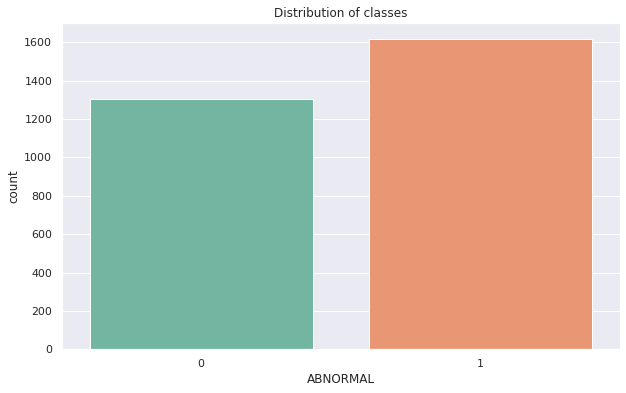

In [57]:
# Distribution of the target variable
plt.figure(figsize=(10,6))
plt.title('Distribution of classes')
sns.countplot(x='ABNORMAL', data=labels, palette='Set2')
labels.ABNORMAL.value_counts()

**Comment:**

* We can see that we have approximate number of samples for both classes; there is no huge gap between the two categories. Thus, we can say that the dataset is almost balanced. But to be precise, we should take into account this little gap in prediction and use a scoring function with significant weights for each class. 

#### Features Exploration

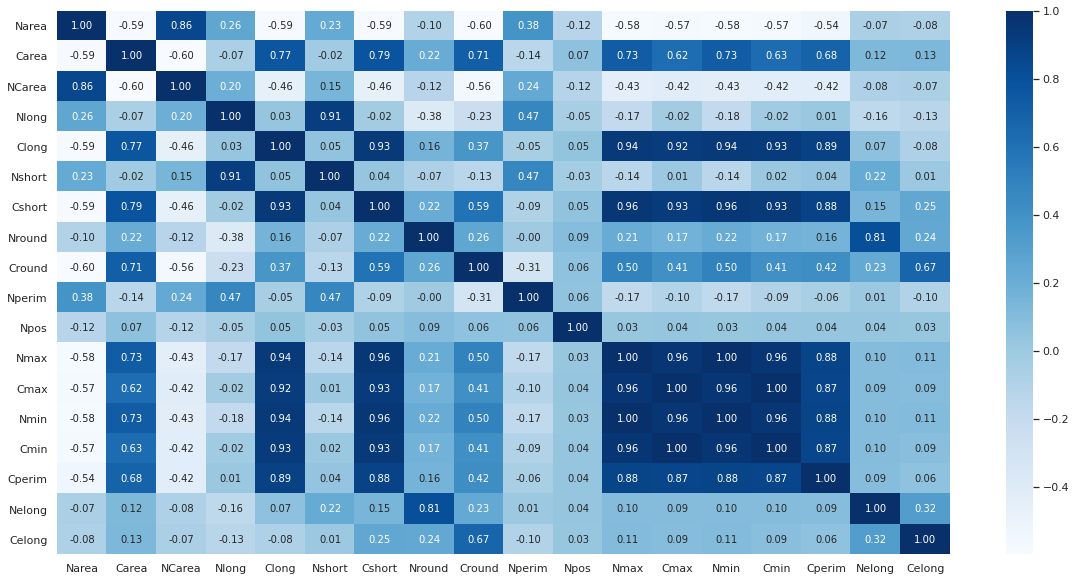

In [6]:
### explore features correlation

plt.figure(figsize=(20,10))
# Drop non-feature columns
ID = df_train['Id']
df_train = df_train.drop(labels='Id', axis=1)
# Plot correlation matrix
corr=df_train.corr()
sns.heatmap(corr,annot=True,fmt='0.2f',cmap=plt.cm.Blues);

**Comment:**

* We can clearly see that we have a block of features that are strongly correlated. This strong correlation should be eliminated since it may worsen the predictive models. <br>
A solution to eliminate this problem is to apply PCA on these features which are : **Nmax, Cmax, Nmin, Cmin, Cperim, Cshort, Clong, and Carea.**

#### Feature engineering : Remove strongly correlated features with PCA

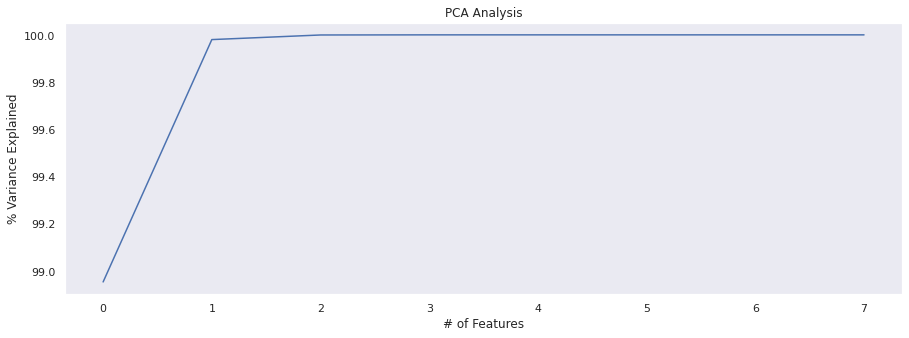

In [7]:
correlated_features = ['Nmax', 'Cmax', 'Nmin', 'Cmin', 'Cperim', 'Cshort', 'Clong', 'Carea']

df_train_ = df_train[correlated_features]

# Determine the number of components 
pca = PCA()
pca.fit(df_train_)   
percentage = pca.explained_variance_ratio_ 
var=np.cumsum(percentage*100)

# Plot the cumulative variance 
plt.figure(figsize=(15,5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.plot(np.arange(len(var)),var)
plt.grid();

**Comment:**

* As we see, only two principle components can explain $100\%$ of the variance. Thus, we replace the $8$ strongly correlated features by the two uncorrelated principle components.

In [8]:
n_components = 2
pca = PCA(n_components = n_components)
df_train_pca = pca.fit_transform(df_train_)

data = df_train.drop(columns = correlated_features)
df_train_pca = (data.merge(pd.DataFrame(df_train_pca ,index=data.index , columns=['PC1','PC2']),on=data.index)).set_index(['key_0'])
df_train_pca

,Narea,NCarea,Nlong,Nshort,Nround,Cround,Nperim,Npos,Nelong,Celong,PC1,PC2
key_0,,,,,,,,,,,,
0,0.025005,0.045235,54,51,0.161136,0.162279,73,0.206141,0.944444,0.972332,1.163631e+06,4664.052802
1,0.062571,0.136499,60,38,0.117510,0.077480,93,0.571948,0.633333,0.485000,-7.570650e+05,-16005.668975
2,0.114631,0.303549,67,66,0.193095,0.089122,78,0.334683,0.985075,0.698324,-6.489206e+05,104881.376547
3,0.082627,0.171135,67,47,0.132835,0.154861,70,0.069602,0.701493,0.940000,-7.122613e+05,-19643.932892
4,0.033899,0.063762,50,44,0.172286,0.153175,77,0.172549,0.880000,0.909524,1.915790e+05,-13257.816486
...,...,...,...,...,...,...,...,...,...,...,...,...
2916,0.017449,0.028420,44,40,0.178061,0.137510,64,0.043900,0.909091,0.744108,1.273840e+06,-152647.090584
2917,0.016536,0.025345,52,44,0.178880,0.163166,42,0.034224,0.846154,0.850877,2.716442e+06,-286670.204324
2918,0.008517,0.013645,45,29,0.132068,0.130866,48,0.363974,0.644444,0.718346,3.137130e+06,-180615.952075


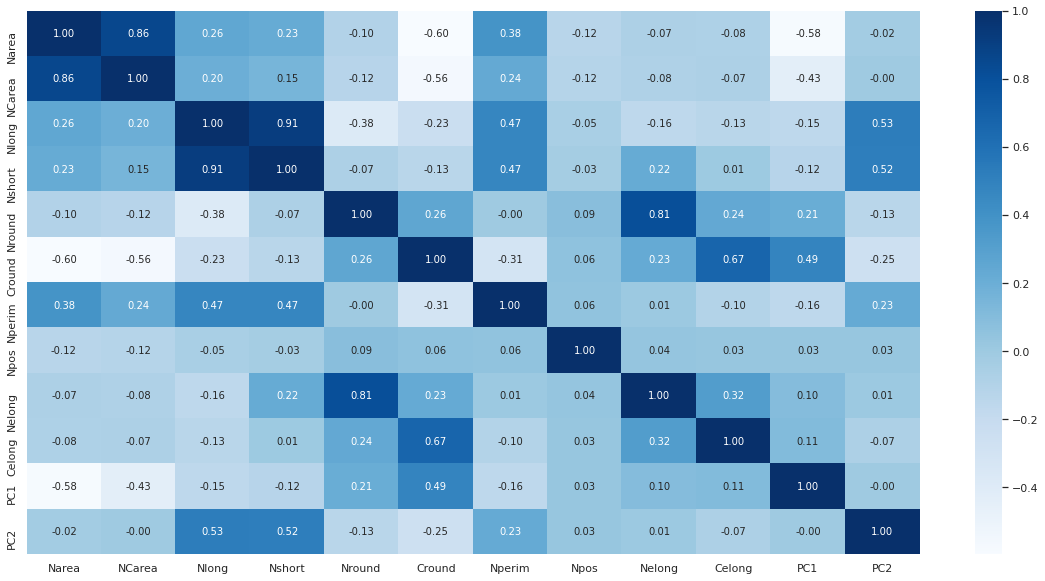

In [9]:
# Check features correlation
plt.figure(figsize=(20,10))
corr=df_train_pca.corr()
sns.heatmap(corr,annot=True,fmt='0.2f',cmap=plt.cm.Blues);

**Comment:**

* As we see, the block of strongly correlated features has been eliminated and the two introduced principle components aren't correlated with other features.

## Pre-modeling

In the pre-modeling step, we : 
* match labels to training images,
* split the training data into train and validation datasets in order to evaluate the performance of the next predictive models,
* and normalize the train and validation datasets.

In [10]:
# Define class names
class_names = ['Normal','Abnormal']

In [11]:
# Match labels to training samples
train_labels = []
train_ids = []
for id_ in ID:
  train_labels.append(labels[labels['ID']==int(id_)]['ABNORMAL'].iloc[0])
  train_ids.append(int(id_))
train_labels=np.array(train_labels)

In [12]:
# Split training dataset into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(df_train_pca, train_labels, test_size=0.25, random_state=42, shuffle=True, stratify=train_labels)

In [13]:
# Define scaler
scaler = StandardScaler()

# Fit scaler on train dataset
scaler = scaler.fit(X_train)

# Transform train and test datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

In this section, I'll try to build algorithms that help us detect automatically abnormality in cell images. In the first part, I'll focus on machine learning algorithms that are based on the handcrafted features. In the second part, I'll try to build deep learning models that create deep features to detect abnormality.

## Machine Learning algorithms - Handcrafted features

As a first step, I have decided to start with a linear classification because it is the simplest technique for binary classification.

### Linear Classifier

Training score: 0.43457132477477867.
Validation score: 0.4454887774849388.

Normalized confusion matrix
[[0.70552147 0.29447853]
 [0.07407407 0.92592593]]


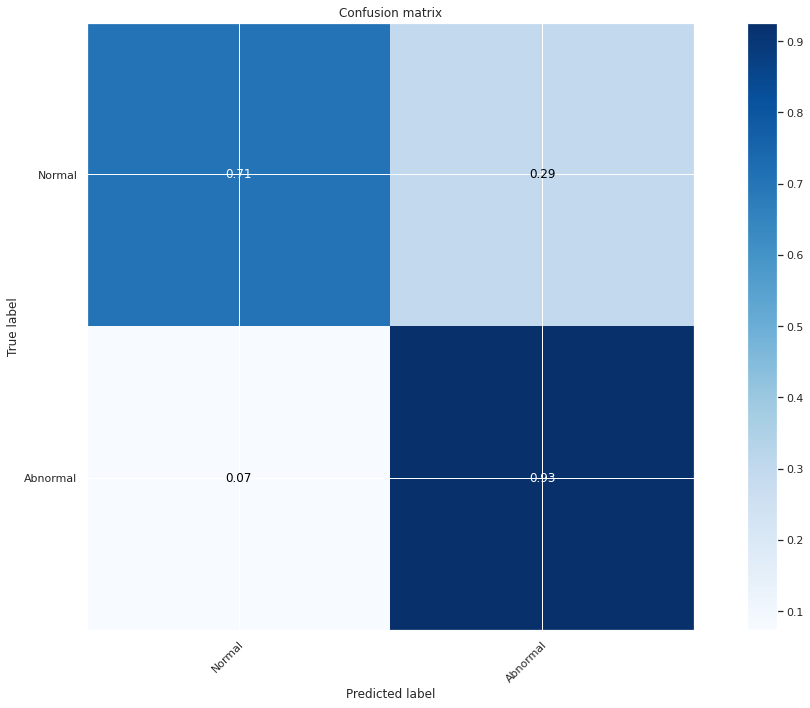

In [40]:
linear_classifier(X_train, y_train,X_test,y_test)

**Comment:**

* As we see, the linear model doesn't work well on our data. It gives an accuracy of $44\%$ for test dataset.
* Besides, as we see from the confusion matrix, we have a significant percentage of false alarms (around $30\%$).
* Contrariwise, the percentage of missing cases which are the false negatives is low ($7\%$) and our aim is to reduce further this percentage since in medical engineering it is better to incorrectly predict normal cells as abnormal than to predict abnormal cells as normal. 

**Interpretation:**

* I think that the results are not satisfying since the dataset is more complicated than to be linearly modelized. I can say then that the linear model is too simple for our dataset.

### SVM Classifier

To solve the previous problem of non linearity in our data. I decided to apply SVM classifier because it can handle non linear datasets. In fact, the SVM classifier can find complex relationships and do necessary transformations on its own when using a specific kernel.<br>
For this task, I choose the Gaussian Radial Basis Function (RBF) kernel.

 Average and std TRAIN CV accuracy : 0.8600456621004566 +- 0.005655007340867979
 Average and std TEST CV accuracy : 0.8424657534246576 +- 0.025341437306870527
Normalized confusion matrix
[[0.7392638  0.2607362 ]
 [0.05925926 0.94074074]]


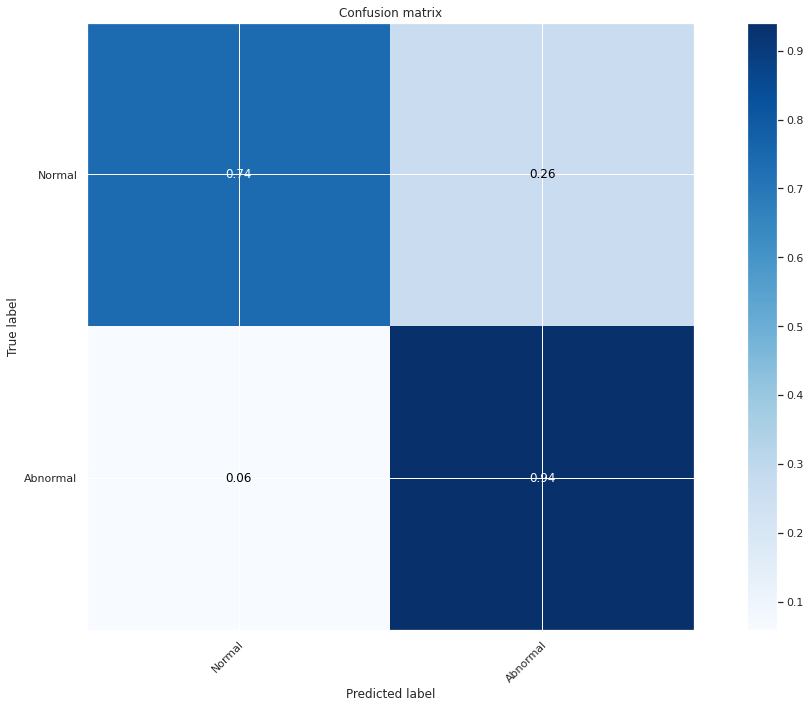

In [44]:
estimator_best = SVM_classifier(X_train, y_train,X_test,y_test)

**Comment:**

* As we see, the SVM classifier worked relatively good on our dataset with accuracy reaching $84\%$ on test dataset.
* Then, as it is possible to see from the confusion matrix, the percentage of false negatives decreased, as well as the false positives. 
* However, we still have a significant number of false positives that we aim to reduce. I think this can be related to the fact that abnormal cells samples are more than normal cells samples which make the model learn more on abnormal cells and thus predict some of the normal cells as abnormal.

We try to interprete these results by showing some misclassified cell images and the distribution of Nareac and Carea range of values.


ID 1768: Normal cell predicted as Abnormal


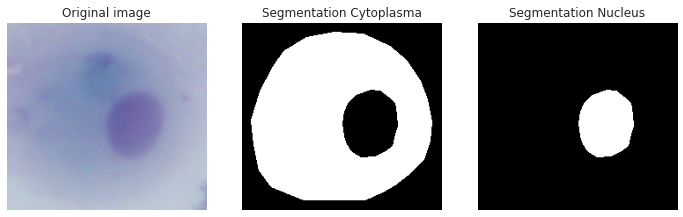


ID 1170: Normal cell predicted as Abnormal


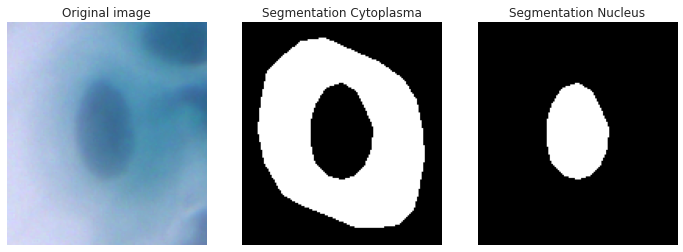


ID 3705: Normal cell predicted as Abnormal


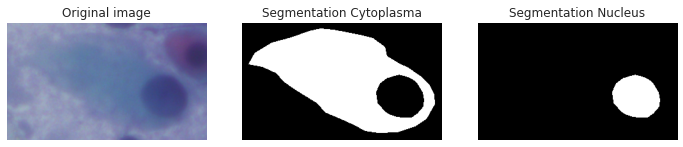

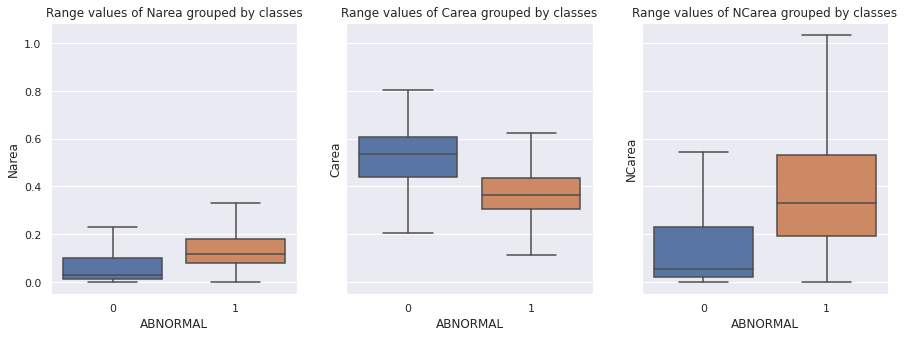

In [47]:
misclassified_samples_(estimator_best,df_train_pca,train_labels,class_names,ID,path_images),print()
NareaCarea_distribution(df_train,train_labels)

**Interpretation:**

* From results in the previous images and boxplot figures, it is possible to see that normal cells have smaller area of nucleus region and bigger area of cytoplasm regions which leads to smaller values of NCarea ratio. Contrary to abnormal images which are most characterized by bigger nucleus area and smaller cytoplasm area.
<br>
However, some of the previous cell images represent big area of nucleus regarding cytoplasm area but are labeled as normal by experts. Thus, we can consider these examples as outliers in our dataset. And as SVM are very sensitive to outliers, the model wrongly classified these samples.

### Decision Tree

It's commonly known that Decision Trees are robust to outliers. Besides, in most of the cases, they are good classifiers towards slightly non balanced datasets. Thus, I decided to try to improve the results by applying a tree classifier. <br><br>
As Decision trees easily overfit. Thus, I'll use cross validation to tune its hyperparameters and then select the best model. I chose for that a 5-fold cross validation scheme.

Best parameters :  {'max_leaf_nodes': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree train accuracy : 0.8347031963470319
Decision Tree test accuracy : 0.8180574555403557

Normalized confusion matrix
[[0.7791411  0.2208589 ]
 [0.15061728 0.84938272]]
CPU times: user 38.1 s, sys: 0 ns, total: 38.1 s
Wall time: 38 s


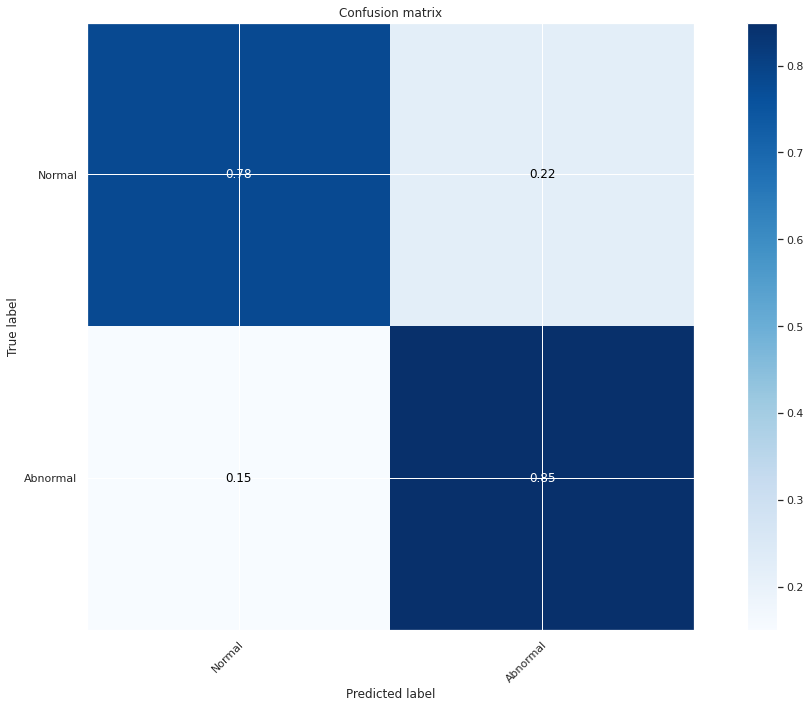

In [48]:
%%time
Decision_Tree_Classifier(X_train, y_train,X_test,y_test)

**Comment:**
* Through these results, we can say that the Decision Tree is efficient in abnormality detection in cell images. In fact, it gives a score of $81,8\%$ on test dataset. However, it didn't outperform the SVM classifier ; the false negatives percentage increased which means that the model classified more abnormal cells as normal. This can be related to the fact that being more robust to outliers, the decision tree learned from these outliers and generalized it on other samples. I suppose that the data has a non negligeble percentage of this kind of outliers so that the model learned on them. These samples are most likely in the overlap of NCarea ratio between the two classes represented by the last boxplot. 

### Random Forest

As seen, a single tree was not sufficient for producing better predictions. To improve the results the Random Forest classifier comes to the picture. In fact, the Random Forest classifier is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions, which improves almost in all cases the prediction results.<br>
Thus, we'll apply now Random Forest in order to ameliorate the last results.

Best params: {'max_features': 'sqrt', 'max_leaf_nodes': 19, 'min_samples_leaf': 6, 'n_estimators': 15}
Decision Tree train accuracy : 0.867579908675799
Decision Tree test accuracy : 0.8508891928864569
Normalized confusion matrix
[[0.7392638  0.2607362 ]
 [0.05925926 0.94074074]]
CPU times: user 2min 48s, sys: 761 ms, total: 2min 49s
Wall time: 2min 48s


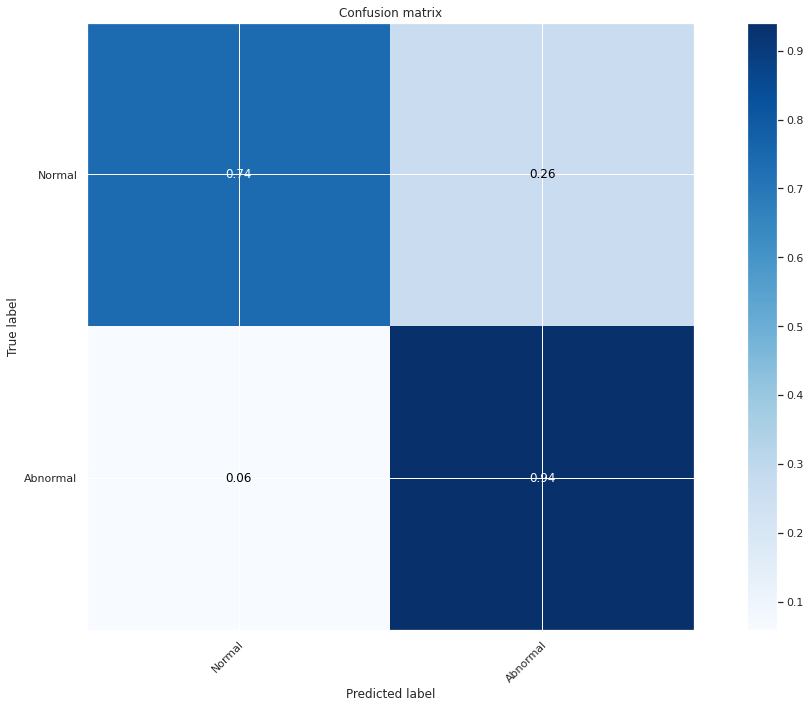

In [49]:
%%time
best_model_RF = Random_Forest_Classifier(X_train, y_train,X_test,y_test,multiclass=False)

**Comment:**

* As expected, the Random forest classifier improved the Decision tree results as the score on test dataset imptoved from $81,5\%$ to $85\%$ which outperformed the SVM classifier results. This is most likely related to the fact that, on one hand, the Random forest is robust to outliers unlike SVM, and on the other hand, Random forest averages the results of many decision trees classifiers which improves the results further.

The Random Forest classifier is also used in Machine learning algorithms to determine features importances and thus select the most important predictive variables and eliminate the least important ones.

### Feature Selection with Random Forest

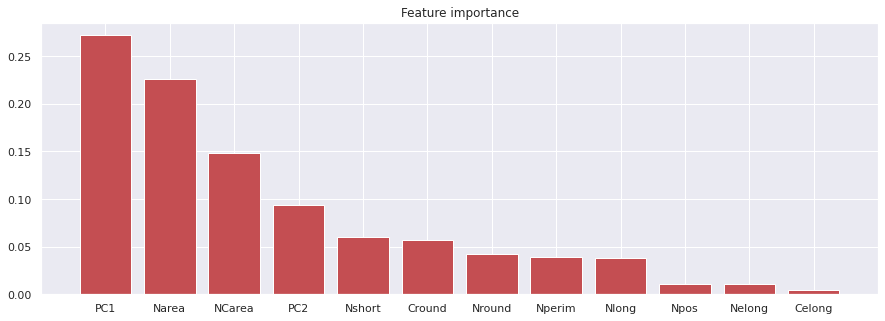

In [50]:
plot_features_importance(best_model_RF, df_train_pca)

**Comment:**

* As expected, the most important features are the features related to the area of the two regions of interest **Narea, NCarea** and the first principle component **PC1**. They had a strong contribution to predict cells classes. Whereas the least important features are related to the **elongation** of the two regions. 

### Gradient Boosting Classifier

We saw Random Forest classifier that builds an ensemble of deep independent trees and turned to be very efficient regarding Decision Trees and other machine learning algorithms. Now, we'll see another method to combine predictions of several trees known as Boosting technique which is used as an Ensemble Method in Machine Learning. 

Gradient boosting machines build an ensemble of shallow and weak successive trees with each tree learning and improving on the previous. When combined, these many weak successive trees produce a powerful “committee” that is very efficient.

Gradient Boosting train accuracy: 0.9739726027397261
Gradient Boosting test accuracy : 0.8563611491108071
Normalized confusion matrix
[[0.79754601 0.20245399]
 [0.0962963  0.9037037 ]]
CPU times: user 18min 54s, sys: 2.91 s, total: 18min 57s
Wall time: 18min 53s


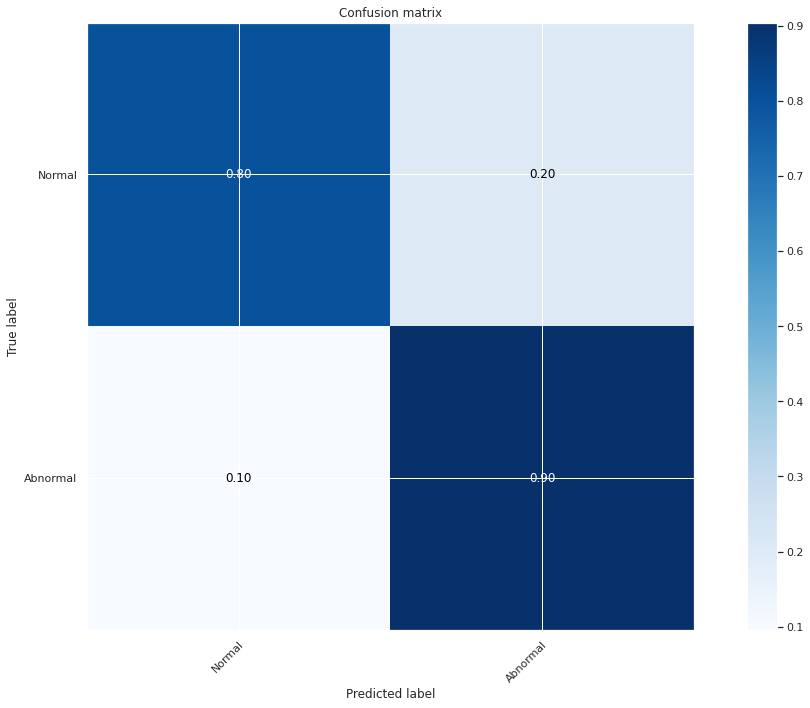

In [40]:
%%time
Gradient_Boosting_Classifier(X_train, y_train,X_test,y_test)

**Comment:**

* As we see, the gradient boosting classifier fits perfectly the training data as it gives $97.3\%$ of accuracy on train dataset. But it gives satisfactory results of $86\%$ on test dataset. We can say thus that this classifier slightly overfits compared to the Random Forest classifier.

## Conclusion on Machine Learning Algorithms

So far, I built and applied different machine learning models for the classification  of normal and abnormal cells  by  considering  texture  and  regions  based  features calculated  from  nucleus  and  cytoplasm  of  cervical  cells. Experimental results show that accuracy of **Random Forest** classifier outperforms  the other  classification  techniques achieving $86\%$ on train dataset and $85\%$ on test dataset. 

In next part, I'll try to build and apply Deep Convolutional Neural Network models for this task since their success has emerged in machine learning field and they appear more and more in plentiful tasks.

## Deep learning algorithms - Deep features


The astonishing accuracy and reproducibility of deep neural networks in computer vision have made them a frontline candidate to tackle such challenges. In this regard, I'll try to build specifically a CNN model to classify normal and abnormal cervical cells.

In this part of deep learning, no feature extraction step is required. The CNN is to learn a suitable internal representation automatically, given raw input RGB values.

In [15]:
# Retrive training and test images
train_all_images = filelist(Working_dir + 'Train', 'bmp')
test_all_images = filelist(Working_dir + 'Test', 'bmp')

# Fixe shape of images that would be feed to the CNN architecture
shape=(400,400,3)

# Load data
train_images, y, _ = load_data(train_all_images, shape=shape,labels=labels)

In [43]:
# Split training images into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(train_images, y, test_size=0.15, random_state=42,stratify=y)

### Transfer Learning 

A study [6] on Pap smear classification task has shown that transfer learning gives better results. They have trained five class single-cell Pap smear images from SIPaKMeD on top ten pre-trained image classification architectures which were selected from Keras Applications based on their top $1\%$ accuracy. Their experimental result demonstrated that **DenseNet169** outperformed the selected $10$ pre-trained architectures. <br>
Thus, I chose the **DenseNet169**[4] architecture pre-trained on ImageNet[5]to retrain for this task. 
<br><br>


![](https://drive.google.com/uc?export=view&id=1U50C_UOW-GKduYw3Z-awzX-1LJIGh6zv) <br>
Figure1. Transfer Learning of a pretrained model[7]



<br><br>
The output layers of the selected architecture are fine-tuned from $1000$ classes to $9$ classes and retrained.
I selected $10$ layers to fine-tune and added an ANN architecture to tune further the model on our specific dataset and left the other layers frozen.

I used basically the same architecture with few modification on output layer activation set to **sigmoid** with $1$ unit, and loss functionn set to **binary_crossentropy**.



In [54]:
model = create_model_binary(dropout_rate = 0.1, lrate=0.00003, finetuned_layers=10, shape=shape)

A CNN model overfits after a large number of epochs. To avoid this problem, I used `EarlyStopping` and set monitor to validation accuracy with patience = $10$.

The parameters I chose to train the Deep CNN model are the following :

* dropout rate = 0.1
* learning rate = 0.00003
* batch size = 16
* number of epochs = 100.

In [55]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='auto', 
                               patience = 10)
call = [early_stopping]

We train now the model.

In [56]:
batch_size = 16
epochs = 100

history = model.fit(X_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test),
                    callbacks = call)

Epoch 1/100
156/156 [==============================] - 102s 403ms/step - loss: 0.0000e+00 - accuracy: 0.7544 - val_loss: 0.0000e+00 - val_accuracy: 0.6538
Epoch 2/100
156/156 [==============================] - 57s 364ms/step - loss: 0.0000e+00 - accuracy: 0.8967 - val_loss: 0.0000e+00 - val_accuracy: 0.7654
Epoch 3/100
156/156 [==============================] - 57s 364ms/step - loss: 0.0000e+00 - accuracy: 0.9084 - val_loss: 0.0000e+00 - val_accuracy: 0.9248
Epoch 4/100
156/156 [==============================] - 57s 365ms/step - loss: 0.0000e+00 - accuracy: 0.9282 - val_loss: 0.0000e+00 - val_accuracy: 0.9385
Epoch 5/100
156/156 [==============================] - 57s 364ms/step - loss: 0.0000e+00 - accuracy: 0.9218 - val_loss: 0.0000e+00 - val_accuracy: 0.9544
Epoch 6/100
156/156 [==============================] - 57s 364ms/step - loss: 0.0000e+00 - accuracy: 0.9421 - val_loss: 0.0000e+00 - val_accuracy: 0.9499
Epoch 7/100
156/156 [==============================] - 57s 364ms/step - los

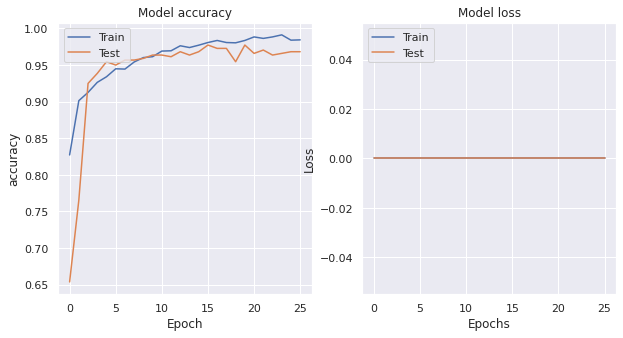

In [58]:
# Plot train and validation accuracy curves 
plot_accuracy_loss_curves(history)

**Comment:**

* As we see from the above figure, the model has learned along $35$ epochs. The train and test accuracies increase progressively and they are very close which means that the model does not overfit until epoch $30$.

#### Model Evaluation

To evaluate the model, we use the Matthews correlation coefficient (MCC), defined as:


![](https://drive.google.com/uc?export=view&id=1QNl4dM5x_DtnDbksMyGIBvZiVmfAs9VN) 

In [59]:
# Make predictions
predictions_train = np.rint(model.predict(X_train)).reshape(y_train.shape[0])
predictions_test = np.rint(model.predict(X_test)).reshape(y_test.shape[0])

# Compute MCC
print('MCC score on train dataset : ', matthews_corrcoef(y_train,predictions_train))
print('MCC score on test dataset : ', matthews_corrcoef(y_test,predictions_test))

MCC score on train dataset :  0.9983690966819463
MCC score on test dataset :  0.9365452751009201


**Comment:**

* As we see, the $DenseNet169$ model worked very well on our dataset and gave us good MCC scores : $99.8\%$ on train dataset and $93.6\%$ on validation dataset.

### Predictions & submission file

In [60]:
# Load test images for submission
test_images_sub, _, test_id = load_data(test_all_images, shape=(400,400,3), test=True)

In [ ]:
'''

### Predictions on unseen data
y_pred = np.rinta(model.predict(test_images_sub)).reshape(y_pred.shape[0])

### For submission
dic = {}
for i,j in zip(test_id,y_pred) :
  dic[str(i)]=j

df = pd.read_csv('SampleSubmission.csv')
test_ID = df['ID']
test_ID = np.asarray(test_ID.tolist())

predictions = []
for i in range(len(dic)) :
  predictions.append(dic[str(test_ID[i])].astype(int))

### Create submission file
sub = pd.DataFrame({'ID': test_ID, 'ABNORMAL': predictions})
sub.to_csv('SampleSub.csv', index=False)

'''

## Conclusion 

To conclude on the first goal of this project, I built several machine learning models in first part that detect abnormality in pap smear cells based on shape and texture features that I extracted from the cytoplasm and nucleus segmentations. I succeeded in obtaining an accuracy of  $86\%$  for training dataset and  $85\%$  for test dataset thanks to the **Random Forest** classifier. In the second part, I used transfer learning with the pretrained **DenseNet169** architecture and retrained it on the provided dataset. This model gave us an accuracy of  $99.8\%$  for the training dataset and  $94.5%$  on the test dataset.<br>
Thus, the deep learning approach outperformed the machine learning approach with a difference of almost $9.5\%$ in accuracy on test dataset.

# **Second Goal: Multi-class Classification**

> In this section, I'll try to classify automatically cell images into **nine different classes** using machine learning algorithms based on the extracted features characterizing both cytoplasm and nucleus regions.

First, we plot samples of cell categories to explore their differences and characteristics.

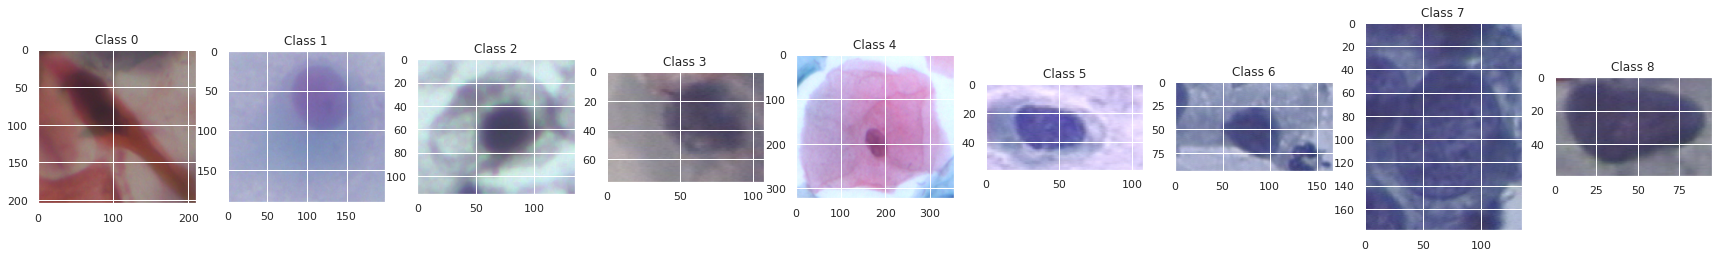

In [51]:
plot_samples_cell_categories(Working_dir,labels)

**Comment:**

* Class 0 cells seem to be flat with oval or polygonal shape. The cytoplasm area seems to be large with a central pycnotyc nucleus.

* Class 1 cells seem to have large round vesicular nucleus and it's difficult to distinguish the cytoplasm borders.

* Class 2 cells seem to have a very dense stained periphery of the cytoplasm.

* Class 3 are with difficult distinguishable cytoplasm margins.

* Class 4 cells seem to have prominent cellular borders, almost round shape of cytoplasm. We note that this class cells may have similar morphological characteristics with class 1 especially regarding cytoplasm region.

* Class 5 has relatively easy recognized nuclear limits.

* The next 3 classes have darker stained cytoplasm that we could not tell about the borders between cytoplasm and nucleus regions.


We plot now the distribution of the $9$ different classes.

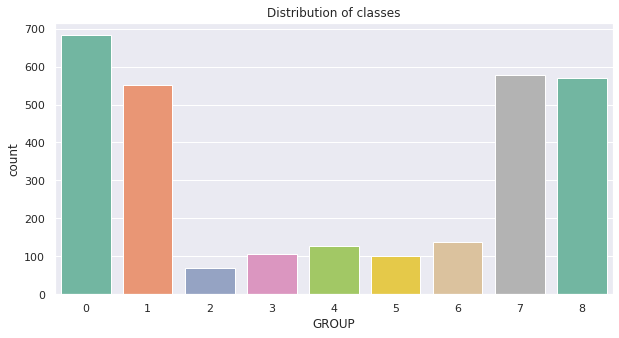

In [70]:
plt.figure(figsize=(10,5))
plt.title('Distribution of classes')
sns.countplot(x='GROUP', data=labels, palette='Set2');

**Comment:**

* It's very clear that the data is **unbalanced**. We have very few samples of the 5 classes : **2, 3, 4, 5, and 6** regarding the other classes.
* The first class constitues the majority of the cells in this pap test.
* The 3 other classes has approximate number of samples.

## Pre-modeling

We match first the group labels to the training samples.

In [52]:
# Match labels to training samples
train_labels = []
train_ids = []
for id_ in ID:
  train_labels.append(labels[labels['ID']==int(id_)]['GROUP'].iloc[0])
  train_ids.append(int(id_))
train_labels=np.array(train_labels)

We split the training data into train and validation datasets in order to fine-tune the hyperparameters and to evaluate the model.

As we have severe imbalance in our data, we should use `stratify` parameter in order to conserve that distribution in both train and validation datasets so that we are sure that all classes belong to each of the datasets. 

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_train_pca, train_labels, test_size=0.25, random_state=42, shuffle=True, stratify=train_labels)

We normalize the numerical features using `StandardScaler`.

In [54]:
# Define scaler
scaler = StandardScaler()

# Fit scaler on train dataset
scaler = scaler.fit(X_train)

# Transform train and test datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

In this section, I'll try to build algorithms that help us classify pap smear cell images automatically. In the first part, I'll focus on machine learning algorithms that are based on the handcrafted features. In the second part, I'll try to build deep learning models that create deep features to classify cells.

## Machine Learning algorithms - Handcrafted features

As a first step, I have decided to start with a linear classification because it is the simplest technique for multi-class classification.

### Linear Classifier

Training score: 0.33712054203270153.
Validation score: 0.31155463098341496.

Normalized confusion matrix
[[0.95906433 0.01169591 0.         0.         0.         0.
  0.         0.00584795 0.02339181]
 [0.04347826 0.70289855 0.         0.         0.         0.
  0.         0.0942029  0.15942029]
 [0.         0.05882353 0.         0.17647059 0.         0.
  0.11764706 0.17647059 0.47058824]
 [0.         0.         0.         0.42307692 0.         0.
  0.46153846 0.07692308 0.03846154]
 [0.03125    0.59375    0.         0.         0.03125    0.
  0.09375    0.1875     0.0625    ]
 [0.         0.36       0.         0.         0.         0.
  0.32       0.32       0.        ]
 [0.         0.08571429 0.         0.11428571 0.         0.
  0.62857143 0.05714286 0.11428571]
 [0.02758621 0.26896552 0.         0.         0.         0.
  0.         0.26896552 0.43448276]
 [0.         0.04929577 0.         0.         0.         0.
  0.         0.06338028 0.88732394]]


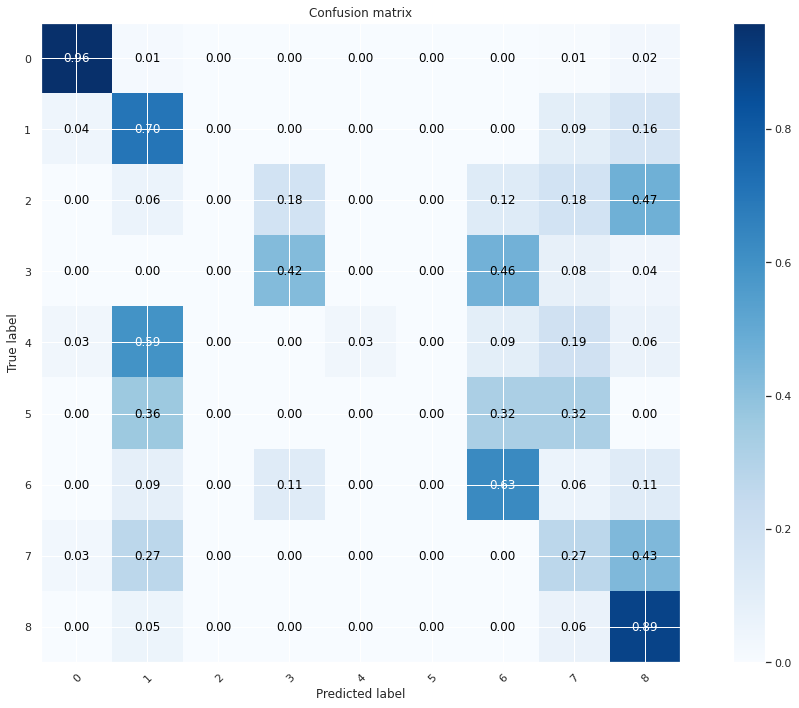

In [61]:
linear_classifier(X_train, y_train,X_test,y_test,multiclass=True)

**Interpretation:**

* As we see, the linear classifier is a bad model. It is not suited for our data ; it gives an accuracy of only $33\%$ on train dataset and $31\%$ on test dataset.
* Besides, we notice that there are classes that are completely wrongly classified : **Class 2, 4 and 5**. I think that is related to the fact that we have very low samples of these classes regarding other classes. So the model didn't learn well on these samples. 
* We can also remark that Class 3 is almost half predicted as Class 6. I think this is due to the fact that these two classes have very close morphological characteristics. In fact, as seen in the previous figure of cell samples : Class 3 has very large (dark) nucleus and not distinguishable cytoplasm borders, while Class 6 has dark cytoplasm region. We can say that due to the non sufficient samples, the model didn't learn well and confused between the large (dark) nucleus and the combined dark cytoplasm and nucleus regions.


* I also think that the results are not satisfying since the dataset is more complicated than to be linearly modelized. I can say then that the linear model is too simple for our dataset.

### SVM Classifier

Next, I decided to apply SVM classifier because it can handle non linear datasets. Since SVM originally separates two categories, I followed the one-versus-one approach by setting `decision_function_shape='ovo'` ; applying each classifier to a test pattern would give one vote to the winning class, so a test pattern is then labeled to the class with the most votes.

 Average and std TRAIN CV accuracy : 0.7401826484018265 +- 0.002265917036675724
 Average and std TEST CV accuracy : 0.7173515981735159 +- 0.024564342751256203
Normalized confusion matrix
[[0.99415205 0.00584795 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.02173913 0.73188406 0.         0.         0.         0.
  0.         0.1884058  0.05797101]
 [0.         0.05882353 0.17647059 0.05882353 0.         0.
  0.58823529 0.05882353 0.05882353]
 [0.         0.         0.         0.73076923 0.         0.
  0.19230769 0.         0.07692308]
 [0.         0.15625    0.         0.03125    0.53125    0.125
  0.03125    0.125      0.        ]
 [0.         0.         0.         0.12       0.44       0.16
  0.24       0.04       0.        ]
 [0.         0.02857143 0.05714286 0.31428571 0.         0.14285714
  0.4        0.02857143 0.02857143]
 [0.00689655 0.28275862 0.         0.         0.         0.
  0.         0.50344828 0.20689655]
 [0.         0.06338028 0.      

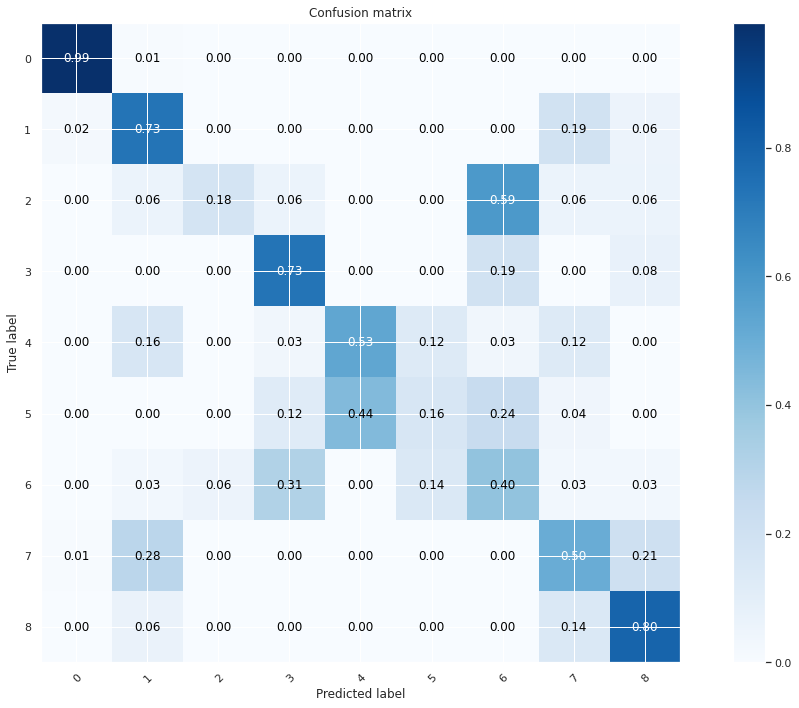

In [62]:
svm_estimator = SVM_classifier(X_train, y_train,X_test,y_test,multiclass=True)

**Interpretation:**

* As expected, the results are ameliorated with a non linear classification. The SVM classifier gave us an accuracy score of $74\%$ on train dataset and $71\%$ on test dataset. And according to the confusion matrix, the model classifies correctly more cells of the classes with least samples.

### Decision Tree

The Decision Trees are known to handle non balanced datasets. Thus, I decided to study the results of a Decision tree on our dataset. <br>
I used a cross validation to fine tune the hyperparameters of the Decision Tree.

Best parameters :  {'max_leaf_nodes': 16, 'min_samples_leaf': 9, 'min_samples_split': 2}
Decision Tree train accuracy : 0.6744292237442923
Decision Tree test accuracy : 0.6292749658002736

Normalized confusion matrix
[[0.98245614 0.00584795 0.         0.         0.         0.
  0.         0.01169591 0.        ]
 [0.         0.43478261 0.         0.         0.05072464 0.01449275
  0.         0.39130435 0.10869565]
 [0.         0.         0.11764706 0.05882353 0.         0.
  0.23529412 0.11764706 0.47058824]
 [0.         0.         0.03846154 0.57692308 0.         0.03846154
  0.30769231 0.         0.03846154]
 [0.         0.1875     0.         0.         0.34375    0.3125
  0.0625     0.03125    0.0625    ]
 [0.         0.08       0.         0.04       0.16       0.4
  0.2        0.12       0.        ]
 [0.         0.02857143 0.08571429 0.28571429 0.02857143 0.11428571
  0.4        0.         0.05714286]
 [0.02068966 0.16551724 0.         0.         0.06206897 0.0137931
  0.         0.

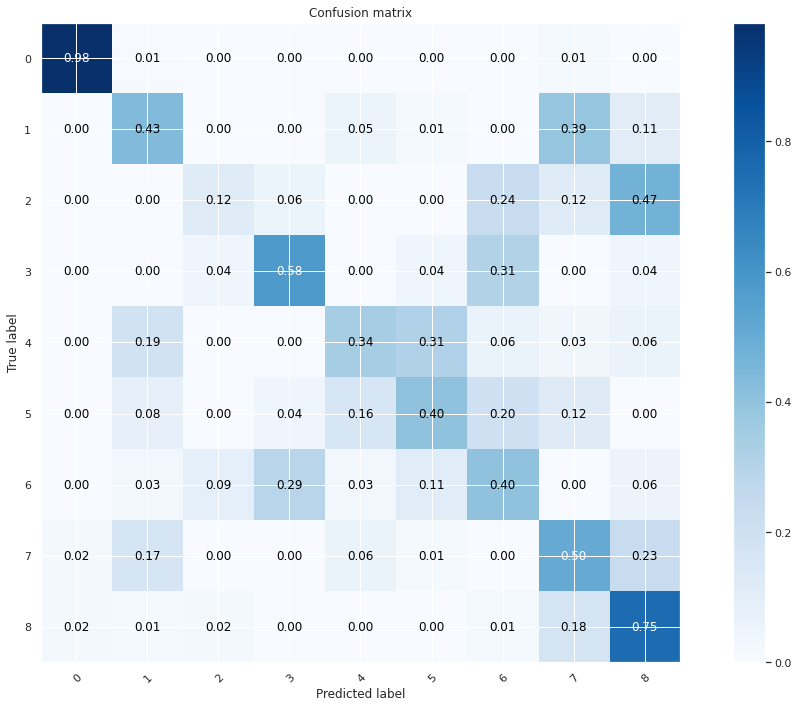

In [63]:
Decision_Tree_Classifier(X_train, y_train,X_test,y_test,multiclass=True)

**Comment:**

* As we see, the Decision tree didn't outperform the SVM classifier. I think this is related to the fact that the decision surfaces for a decision tree are **very complex**. Whereas the decision boundary of the SVM is **very smooth**. Consequently, the SVM is the least sensitive to non balanced data, thus, it performs better on our data.

### Random Forest

To improve the results of the Decision Tree, we can apply the Random Forest classifier which leverages the power of multiple decision trees for making decisions, which improves almost in all cases the prediction results.

Best params: {'max_features': 'sqrt', 'max_leaf_nodes': 19, 'min_samples_leaf': 6, 'n_estimators': 25}
Decision Tree train accuracy : 0.7109589041095891
Decision Tree test accuracy : 0.679890560875513
Normalized confusion matrix
[[0.98830409 0.01169591 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.71014493 0.         0.         0.         0.
  0.         0.24637681 0.04347826]
 [0.         0.05882353 0.05882353 0.05882353 0.         0.
  0.23529412 0.11764706 0.47058824]
 [0.         0.         0.         0.65384615 0.         0.
  0.30769231 0.         0.03846154]
 [0.         0.1875     0.         0.         0.28125    0.0625
  0.1875     0.25       0.03125   ]
 [0.         0.08       0.         0.08       0.08       0.12
  0.36       0.28       0.        ]
 [0.         0.02857143 0.05714286 0.28571429 0.02857143 0.02857143
  0.48571429 0.02857143 0.05714286]
 [0.03448276 0.25517241 0.         0.         0.0137931  0.
  0.0137931  0.50344828 0

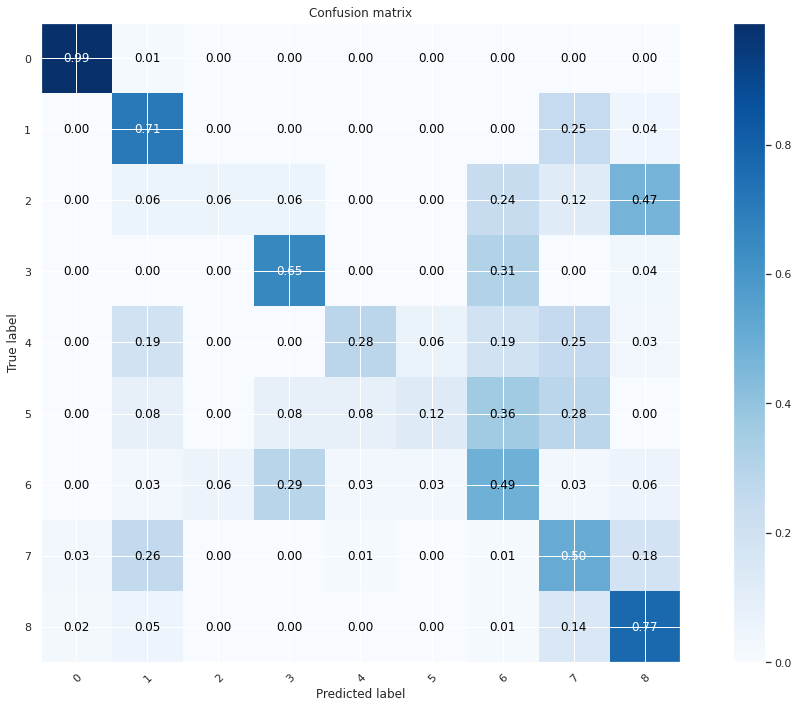

In [64]:
best_model_RF = Random_Forest_Classifier(X_train, y_train,X_test,y_test,multiclass=True)

**Comment:**

* As expected, the Random Forest classifier improved the Decision Tree results as the train score increased from $67\%$ to $71\%$ and the test score increased from $62\%$ to $67\%$. 
* However, the Random Forest didn't outperfom SVM classifier, this is also related to the fact that the decision surfaces of the Random Forest are too complex, unlike the SVM boundary.

### Feature Selection with Random Forest

We can use the Random Forest classifier to determine features importance and thus select the most important and eliminate the least important.

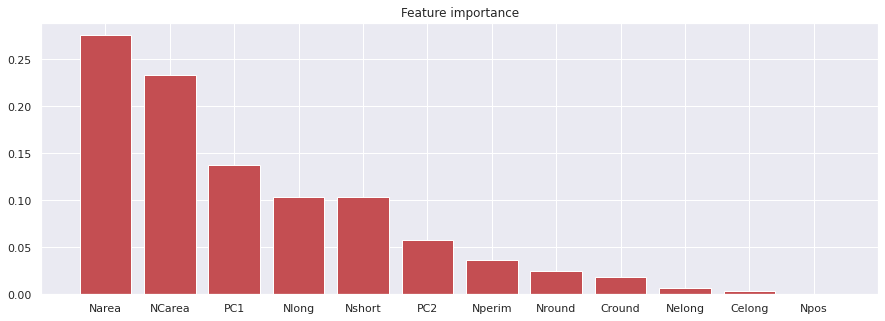

In [65]:
plot_features_importance(best_model_RF, df_train_pca)

**Comment:**

* The above figure brings to the fore how some features are not important and do not change much in the prediction process. 
* **Npos** is with almost null importance so it would be better to eliminate this feature from the dataset.

### Gradient Boosting Classifier

We saw Random Forest classifier that builds an ensemble of deep independent trees. Now, we'll see another method to combine predictions of several trees known as Boosting technique which is used as an Ensemble Method in Machine Learning. 

Gradient boosting machines build an ensemble of shallow and weak successive trees with each tree learning and improving on the previous.

Gradient Boosting train accuracy: 1.0
Gradient Boosting test accuracy : 0.6949384404924761
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.00724638 0.67391304 0.         0.         0.00724638 0.
  0.         0.2826087  0.02898551]
 [0.         0.05882353 0.29411765 0.05882353 0.         0.05882353
  0.17647059 0.17647059 0.17647059]
 [0.         0.         0.07692308 0.53846154 0.         0.03846154
  0.30769231 0.03846154 0.        ]
 [0.         0.15625    0.         0.03125    0.46875    0.0625
  0.0625     0.21875    0.        ]
 [0.         0.04       0.         0.12       0.16       0.16
  0.24       0.28       0.        ]
 [0.         0.02857143 0.08571429 0.31428571 0.08571429 0.08571429
  0.34285714 0.02857143 0.02857143]
 [0.00689655 0.22068966 0.         0.         0.00689655 0.
  0.         0.60689655 0.15862069]
 [0.02112676 0.06338028 0.         0.         0.         0.
  0.         0.16901408

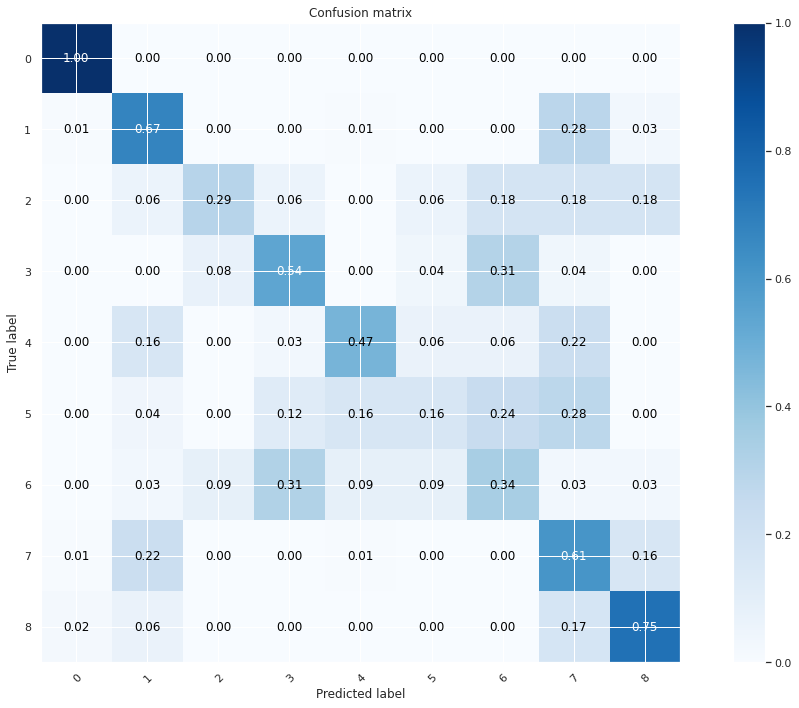

In [133]:
%%time
Gradient_Boosting_Classifier_multiclass(X_train, y_train,X_test,y_test)

**Comment:**

* As we see, the gradient boosting classifier fits perfectly the training data as it gives $100\%$ of accuracy on train dataset. But it gives low results of around $70\%$ on test dataset. We can say thus that this classifier overfits a little compared to the Random Forest classifier.

## Conclusion on Machine Learning Algorithms

So far, I built and applied different machine learning models for the classification of cells into $9$ different categories by  considering  texture  and  regions  based  features calculated  from  nucleus  and  cytoplasm  regions of cervical  cells. Experimental results show that accuracy of **SVM Classifier** outperforms  the other  classification  techniques achieving $74\%$ on train dataset and $71\%$ on test dataset. 

In next part, I'll try to build and apply Deep Convolutional Neural Network models for this task since their success has emerged in machine learning field and they appear more and more in plentiful tasks.

## Deep learning algorithms - Deep features


As in the first part of this project, I'll try to build a CNN model but to classify cervical cells into $9$ different classes.

In this part of deep learning, no feature extraction step is required. The CNN is to learn a suitable internal representation automatically, given raw input RGB values.

### Transfer Learning 

I'll use basically the motivated approach of the Binary classification goal : Transfer learning on $DenseNet169$ model with few modification on output layer activation, set to **softmax** with $9$ units, and loss functionn, set to **categorical_crossentropy**

In [23]:
# Load data
train_images, y, _ = load_data(train_all_images, shape=shape,labels=labels,col='GROUP')

In [24]:
# Split training images into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(train_images, y, test_size=0.15, random_state=42,stratify=y)

In [25]:
model = create_model_multiclass(shape=shape,dropout_rate = 0.1, lrate=0.00003, finetuned_layers=8)

A CNN model overfits after a large number of epochs. To avoid this problem, I used `EarlyStopping` and set monitor to validation accuracy with patience = $20$.

The parameters I chose to train the Deep CNN model are the following :

* dropout rate = 0.1
* learning rate = 0.00003
* batch size = 10
* number of epochs = 100.

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               restore_best_weights = True, 
                               patience = 20)

call = [early_stopping]

In [20]:
batch_size = 10
epochs = 100
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

history = model.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      callbacks = call)

Epoch 1/100
249/249 [==============================] - 106s 271ms/step - loss: 2.1577 - accuracy: 0.2366 - val_loss: 2.3519 - val_accuracy: 0.2164
Epoch 2/100
249/249 [==============================] - 62s 248ms/step - loss: 1.5121 - accuracy: 0.5002 - val_loss: 1.2823 - val_accuracy: 0.6128
Epoch 3/100
249/249 [==============================] - 62s 247ms/step - loss: 1.4171 - accuracy: 0.5386 - val_loss: 1.1631 - val_accuracy: 0.6970
Epoch 4/100
249/249 [==============================] - 62s 247ms/step - loss: 1.3136 - accuracy: 0.6039 - val_loss: 1.0762 - val_accuracy: 0.7358
Epoch 5/100
249/249 [==============================] - 62s 248ms/step - loss: 1.1822 - accuracy: 0.6571 - val_loss: 0.8513 - val_accuracy: 0.7859
Epoch 6/100
249/249 [==============================] - 62s 248ms/step - loss: 1.2258 - accuracy: 0.6277 - val_loss: 0.7961 - val_accuracy: 0.7882
Epoch 7/100
249/249 [==============================] - 62s 247ms/step - loss: 1.0935 - accuracy: 0.6996 - val_loss: 0.7534 

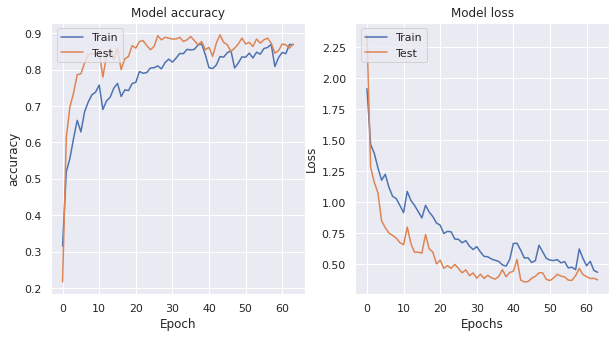

In [21]:
plot_accuracy_loss_curves(history)

**Comment:**

* As we see from the above figure, the model has learned along $58$ epochs. The train and test accuracies increase progressively and they are very close in the last epochs which means that the model does not overfit.

#### Model Evaluation

To evaluate the model, we use the Weighted Categorization Accuracy (WA) defined as:
![](https://drive.google.com/uc?export=view&id=1tRAiQAxSlruRiikUVQRpsTfPGvwJQYfB) 

In [22]:
predictions_train = model.predict_classes(X_train)
predictions_test = model.predict_classes(X_test)

print('MCC score on train dataset : ', balanced_accuracy_score(np.argmax(y_train,axis=1),predictions_train))
print('MCC score on test dataset : ', balanced_accuracy_score(np.argmax(y_test,axis=1),predictions_test))

MCC score on train dataset :  0.9138647127620637
MCC score on test dataset :  0.7141109107580341


**Comment:**

* As we see, the $DenseNet169$ model worked very well on our dataset and gave us good WA scores.

### Predictions & submission file

In [ ]:
# Retrieve test images for submission
test_images_sub, _, test_id = load_data(test_all_images, shape=(400,400,3), test=True)

In [ ]:
'''

# Predictions on unseen data
y_pred = np.rinta(model.predict(test_images_sub)).reshape(y_pred.shape[0])

dic = {}
for i,j in zip(test_id,y_pred) :
  dic[str(i)]=j

df = pd.read_csv('SampleSubmission.csv')
test_ID = df['ID']
test_ID = np.asarray(test_ID.tolist())

predictions = []
for i in range(len(dic)) :
  predictions.append(dic[str(test_ID[i])].astype(int))

# Create submission file
sub = pd.DataFrame({'ID': test_ID, 'ABNORMAL': predictions})
sub.to_csv('SampleSub.csv', index=False)

'''

## **General Conclusion**

> $~~~~$ The classification of  normal and  abnormal cells  from Pap smear  data of cervical cell and assigning cells to specific groups are helpful for  early diagnosis of cervical cancer. The computer assisted techniques can be used for the classification of these cells which otherwise relies on manual analysis by  expert cytologist.
<br>
$~~~~$ In this project, we studied two problems : Abnormality detection in pap smear cells and multi-class classification of these same cells. For both goals, I extracted features from cytoplasm and nucleus segmentations of each cell of the database based on texture and shape features. Based on these handcrafted features I analyzed the results given by several machine learning algorithms. For the Binary Classification goal, I achieved an accuracy of $85\%$ on test dataset with Random Forest classifier. However for Multi-class Classification goal, I achieved an accuracy of $71\%$ on test dataset with SVM classifier.
Nonetheless, in the second study which is based on deep learning, I achieved better scores in both tasks. The Deep learning approach outperformed the Machine Learning approach. With transfer learning and fine tuning the DenseNet169 architecture pretrained on ImageNet database, I reached an MCC score of $95.5\%$ on kaggle competion for the Binary Classification task, and an AW score of $78.6\%$ on kaggle competition for the Multi-class Classification task, which represent a rank of 8/50 in both public leaderboards.


# References

[1] : https://www.researchgate.net/publication/265873515_Pap-smear_Benchmark_Data_For_Pattern_Classification
<br>[2] : https://mde-lab.aegean.gr/downloads
<br>[3] : https://www.cs.uoi.gr/~marina/sipakmed.html
<br>[4] : https://arxiv.org/abs/1608.06993
<br>[5] : https://www.researchgate.net/publication/221361415_ImageNet_a_Large-Scale_Hierarchical_Image_Database
<br>[6] : https://assets.researchsquare.com/files/rs-257282/v1_stamped.pdf
<br>[7] : https://arxiv.org/pdf/1801.08616.pdf
